# Synthetic Data Generation for Dataset Balancing - All Folds

This notebook generates synthetic images to balance the class distribution of all k-fold datasets.

**Pipeline:**
1.  **Configuration:** Set up paths and parameters.
2.  **Analyze Folds:** Analyze the class distribution of all folds to determine the balancing needs.
3.  **Create Object Bank:** Extract objects from the TACO dataset (done once).
4.  **Generate & Balance:** Create synthetic images and add them to the `train` split of each fold.
5.  **Verification:** Verify the final class distribution for each fold.
6.  **Summary:** Provide a comprehensive analysis of all processed folds.

In [1]:
import os
import json
import cv2
import numpy as np
import yaml
from PIL import Image, ImageDraw
import random
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict, Counter
from pathlib import Path

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Configuration

In [2]:
from pathlib import Path

# --- Paths ---
BASE_DIR = Path('/home/andrea/work/AI-waste-detection/')
K_FOLD_CV_DIR = BASE_DIR / 'datasets/k_fold_cv'
BALANCED_FOLDS_DIR = BASE_DIR / 'datasets/k_fold_cv_balanced' # New output directory

TACO_DIR = BASE_DIR / 'datasets/taco_official'
TACO_ANNOTATIONS_PATH = TACO_DIR / 'annotations.json'
OBJECT_BANK_DIR = BASE_DIR / 'datasets/object_bank_for_balancing'

# --- Generation Parameters ---
IMAGE_SIZE = (640, 640)
OBJECTS_PER_IMAGE_RANGE = (2, 7)
SCALE_RANGE = (0.2, 0.7)
ROTATION_RANGE = (-20, 20)
OVERLAP_THRESHOLD = 0.05 # IoU threshold to avoid placing objects on top of each other

# --- Object Bank Parameters ---
OBJECTS_PER_CLASS_IN_BANK = 300
MIN_OBJECT_PIXEL_AREA = 40 * 40

# --- TACO to Target Class Mapping ---
# This mapping connects the TACO dataset categories to our target classes.
# The target class IDs (0, 1, 2, 3, 4) will be confirmed from the fold's data.yaml.
TACO_TO_TARGET_MAPPING = {
    'Aluminium foil': 1, 'Aluminium blister pack': 1, 'Drink can': 1, 'Food Can': 1, 'Pop tab': 1, 'Scrap metal': 1, 'Aerosol': 1, 'Metal lid': 1,
    'Clear plastic bottle': 4, 'Other plastic bottle': 4, 'Plastic bottle cap': 4, 'Other plastic cup': 4, 'Plastic lid': 4, 'Shopping bag': 4, 'Plastic straw': 4, 'Other plastic wrapper': 4, 'Other plastic': 4, 'Styrofoam piece': 4, 'Plastic film': 4, 'Squeezable tube': 4, 'Plastic utensils': 4, 'Tupperware': 4, 'Plastic glooves': 4, 'Lighter': 4,
    'Glass bottle': 0, 'Glass cup': 0, 'Glass jar': 0, 'Broken glass': 0,
    'Paper': 3, 'Paper cup': 3, 'Drink carton': 3, 'Normal paper': 3, 'Tissues': 3, 'Wrapping paper': 3, 'Magazine': 3, 'Carded blister pack': 3, 'Other carton': 3, 'Meal carton': 3, 'Pizza box': 3, 'Paper bag': 3,
    'Food waste': 2,
    'Unlabeled litter': -1, 'Cigarette': -1, 'Shoe': -1, 'Battery': -1, 'Rope & strings': -1, 'Medical waste': -1,
}

# Create directories
OBJECT_BANK_DIR.mkdir(exist_ok=True)
BALANCED_FOLDS_DIR.mkdir(exist_ok=True)


print(f"K-Fold CV Directory: {K_FOLD_CV_DIR}")
print(f"Output Balanced Folds Directory: {BALANCED_FOLDS_DIR}")
print(f"TACO Annotations: {TACO_ANNOTATIONS_PATH}")
print(f"Object Bank: {OBJECT_BANK_DIR}")

# Get all available folds
AVAILABLE_FOLDS = [d.name for d in K_FOLD_CV_DIR.iterdir() if d.is_dir() and d.name.startswith('fold_')]
AVAILABLE_FOLDS.sort()
print(f"Available folds: {AVAILABLE_FOLDS}")

K-Fold CV Directory: /home/andrea/work/AI-waste-detection/datasets/k_fold_cv
Output Balanced Folds Directory: /home/andrea/work/AI-waste-detection/datasets/k_fold_cv_balanced
TACO Annotations: /home/andrea/work/AI-waste-detection/datasets/taco_official/annotations.json
Object Bank: /home/andrea/work/AI-waste-detection/datasets/object_bank_for_balancing
Available folds: ['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5']


## 2. Analyze Folds Structure

Target classes from data.yaml: ['glass', 'metal', 'organic', 'paper', 'plastic']

Initial Class Distribution for fold_1 (train split):
  - glass (ID 0): 851 instances
  - metal (ID 1): 3268 instances
  - organic (ID 2): 1116 instances
  - paper (ID 3): 1974 instances
  - plastic (ID 4): 4594 instances

Initial Class Distribution for fold_1 (train split):
  - glass (ID 0): 851 instances
  - metal (ID 1): 3268 instances
  - organic (ID 2): 1116 instances
  - paper (ID 3): 1974 instances
  - plastic (ID 4): 4594 instances


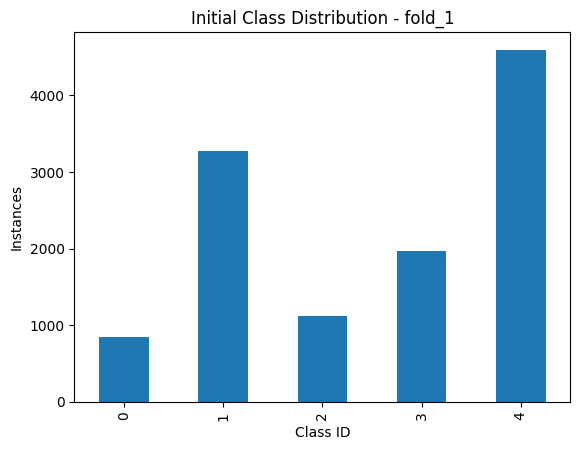

In [3]:
def load_fold_config(fold_dir):
    """Loads the data.yaml file from the fold directory."""
    config_path = fold_dir / 'data.yaml'
    if not config_path.exists():
        raise FileNotFoundError(f"data.yaml not found in {fold_dir}")
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

def get_class_distribution(labels_dir, num_classes):
    """Counts class instances in a directory of YOLO label files."""
    class_counts = Counter()
    if not labels_dir.is_dir():
        return class_counts
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                if class_id < num_classes:
                    class_counts[class_id] += 1
    return class_counts

def analyze_fold_distribution(fold_name):
    """Analyze the class distribution for a specific fold."""
    fold_dir = K_FOLD_CV_DIR / fold_name
    
    try:
        fold_config = load_fold_config(fold_dir)
        target_classes = fold_config.get('names', [])
        num_classes = len(target_classes)
        print(f"Target classes from data.yaml: {target_classes}")

        train_labels_dir = fold_dir / 'train/labels'
        initial_distribution = get_class_distribution(train_labels_dir, num_classes)

        print(f"\nInitial Class Distribution for {fold_name} (train split):")
        if not initial_distribution:
            print("  No labels found or directory does not exist.")
        else:
            for i, class_name in enumerate(target_classes):
                print(f"  - {class_name} (ID {i}): {initial_distribution[i]} instances")

        # Plot initial distribution
        if initial_distribution:
            pd.DataFrame.from_dict(initial_distribution, orient='index').sort_index().plot(kind='bar', legend=False,
                            title=f'Initial Class Distribution - {fold_name}', xlabel='Class ID', ylabel='Instances')
            plt.show()

        return target_classes, num_classes, initial_distribution

    except FileNotFoundError as e:
        print(f"Error analyzing {fold_name}: {e}")
        return [], 0, {}

# For initial demonstration, analyze fold_1
if AVAILABLE_FOLDS:
    TARGET_CLASSES, NUM_CLASSES, initial_distribution = analyze_fold_distribution(AVAILABLE_FOLDS[0])
else:
    TARGET_CLASSES = []
    NUM_CLASSES = 0
    initial_distribution = {}

## 3. Create Object Bank

In [4]:
def polygon_to_mask(polygon, width, height):
    """Convert a COCO segmentation polygon to a binary mask."""
    mask = Image.new('L', (width, height), 0)
    if not polygon:
        return mask
    ImageDraw.Draw(mask).polygon(polygon[0], outline=1, fill=1)
    return np.array(mask)

def find_image_path(image_info, taco_dir):
    """Finds the full path of a TACO image, searching in batch folders."""
    img_filename = image_info['file_name']
    
    # First, check if the filename is already a relative path that exists
    path1 = taco_dir / img_filename
    if path1.exists():
        return path1

    # If not, search inside batch_* subdirectories, which is the standard TACO structure
    if '/' not in str(img_filename) and '\\' not in str(img_filename):
        for d in os.listdir(taco_dir):
            if d.startswith('batch_') and os.path.isdir(taco_dir / d):
                path2 = taco_dir / d / img_filename
                if path2.exists():
                    return path2
    return None

def extract_object(image, segmentation):
    """Extracts an object from an image using its segmentation mask, returning an RGBA image."""
    img_h, img_w = image.shape[:2]
    
    mask = np.zeros((img_h, img_w), dtype=np.uint8)
    for poly in segmentation:
        if len(poly) < 6: continue
        pts = np.array(poly, np.int32).reshape((-1, 2))
        cv2.fillPoly(mask, [pts], 1)

    if np.sum(mask) == 0:
        return None

    # Find bounding box of the mask to crop
    y_indices, x_indices = np.where(mask)
    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()

    # Crop image and mask
    cropped_img_bgr = image[y_min:y_max+1, x_min:x_max+1]
    cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]

    # Create 4-channel RGBA image
    rgba_object = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2RGBA)
    rgba_object[:, :, 3] = cropped_mask * 255 # Apply mask to alpha channel
    
    return Image.fromarray(rgba_object)


def create_object_bank():
    """Creates the object bank by extracting objects from the TACO dataset."""
    print("🌟 Starting Object Bank Creation...")
    
    if not TACO_ANNOTATIONS_PATH.exists():
        print(f"❌ ERROR: Annotations file not found at {TACO_ANNOTATIONS_PATH}")
        return

    with open(TACO_ANNOTATIONS_PATH, 'r') as f:
        taco_data = json.load(f)
    
    print(f"  Loaded {len(taco_data['annotations'])} total annotations.")
    
    images_info = {img['id']: img for img in taco_data['images']}
    categories_info = {cat['id']: cat for cat in taco_data['categories']}

    # Group annotations by our target classes
    class_annotations = defaultdict(list)
    print("  Filtering annotations based on mapping and area...")
    for ann in tqdm(taco_data['annotations'], desc="Filtering annotations"):
        cat_id = ann.get('category_id')
        if cat_id in categories_info:
            supercategory = categories_info[cat_id]['supercategory']
            target_class_id = TACO_TO_TARGET_MAPPING.get(supercategory, -1)
            if target_class_id != -1 and ann['area'] > MIN_OBJECT_PIXEL_AREA:
                class_annotations[target_class_id].append(ann)
    
    print(f"  Found matching annotations for {len(class_annotations)} classes.")
    if not class_annotations:
        print("  ❌ ERROR: No annotations matched the filter criteria. Check TACO_TO_TARGET_MAPPING and MIN_OBJECT_PIXEL_AREA.")
        return

    # Create class directories in object bank
    for class_name in TARGET_CLASSES:
        (OBJECT_BANK_DIR / class_name).mkdir(exist_ok=True)

    # Extract and save objects
    total_extracted_count = 0
    for class_id, class_name in enumerate(TARGET_CLASSES):
        print(f"--- Processing class: {class_name} ---")
        
        object_count = 0
        annotations_for_class = class_annotations[class_id]
        if not annotations_for_class:
            print(f"  No annotations found for this class.")
            continue
            
        random.shuffle(annotations_for_class)
        
        pbar = tqdm(total=min(len(annotations_for_class), OBJECTS_PER_CLASS_IN_BANK), desc=f"Extracting {class_name}")
        
        img_not_found_count = 0
        extraction_failed_count = 0
        for ann in annotations_for_class:
            if object_count >= OBJECTS_PER_CLASS_IN_BANK:
                break

            img_info = images_info.get(ann['image_id'])
            if not img_info: continue
            
            img_path = find_image_path(img_info, TACO_DIR)
            if not img_path:
                img_not_found_count += 1
                continue

            try:
                image = cv2.imread(str(img_path))
                if image is None:
                    extraction_failed_count += 1
                    continue
            except Exception:
                extraction_failed_count += 1
                continue

            extracted_obj = extract_object(image, ann['segmentation'])
            
            if extracted_obj:
                save_path = OBJECT_BANK_DIR / class_name / f"{object_count:04d}.png"
                extracted_obj.save(save_path)
                object_count += 1
                total_extracted_count += 1
                pbar.update(1)
            else:
                extraction_failed_count += 1

        pbar.close()
        print(f"  Extracted {object_count} objects for class '{class_name}'.")
        if img_not_found_count > 0:
            print(f"  Could not find {img_not_found_count} image files.")
        if extraction_failed_count > 0:
            print(f"  Failed to extract {extraction_failed_count} objects.")

    if total_extracted_count == 0:
        print("\n❌ ERROR: Object bank creation finished, but the bank is still empty. Please check the logs above for errors.")
    else:
        print(f"\n✅ Object bank creation complete. Total objects extracted: {total_extracted_count}")


## 4. Generate & Balance

In [5]:
def load_object_bank():
    """Loads the paths of all objects in the bank, organized by class name."""
    object_bank = defaultdict(list)
    print("🔎 Loading Object Bank...")
    if not OBJECT_BANK_DIR.exists():
        print("  Object bank directory not found.")
        return object_bank
        
    for class_dir in OBJECT_BANK_DIR.iterdir():
        if class_dir.is_dir():
            for obj_file in class_dir.glob('*.png'):
                object_bank[class_dir.name].append(obj_file)
    
    print("  Object Bank loaded successfully.")
    for class_name, objects in object_bank.items():
        print(f"  - Found {len(objects)} objects for class '{class_name}'")
    return object_bank

def create_gradient_background(size):
    """Creates a background with a random linear gradient."""
    width, height = size
    color1 = np.random.randint(150, 255, 3)
    color2 = np.random.randint(150, 255, 3)
    
    background = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(height):
        ratio = y / height
        color = (color1 * (1 - ratio) + color2 * ratio).astype(np.uint8)
        background[y, :] = color
        
    return Image.fromarray(background)

def calculate_iou(box1, box2):
    """Calculates IoU for two boxes in (x1, y1, x2, y2) format."""
    x1_i = max(box1[0], box2[0])
    y1_i = max(box1[1], box2[1])
    x2_i = min(box1[2], box2[2])
    y2_i = min(box1[3], box2[3])
    
    inter_area = max(0, x2_i - x1_i) * max(0, y2_i - y1_i)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0

def generate_synthetic_image(object_bank, classes_to_add, image_size):
    """Generates a single synthetic image."""
    background = create_gradient_background(image_size)
    placed_object_bboxes = []
    yolo_annotations = []

    for class_name in classes_to_add:
        class_id = TARGET_CLASSES.index(class_name)
        
        if not object_bank[class_name]: continue

        obj_path = random.choice(object_bank[class_name])
        obj_img = Image.open(obj_path)

        # Random transformations
        scale = random.uniform(*SCALE_RANGE)
        new_size = (int(image_size[0] * scale), int(image_size[1] * scale))
        obj_img.thumbnail(new_size, Image.Resampling.LANCZOS)
        rotation = random.uniform(*ROTATION_RANGE)
        obj_img = obj_img.rotate(rotation, expand=True, resample=Image.Resampling.BICUBIC)

        # Find a valid placement
        for _ in range(50): # 50 attempts
            pos_x = random.randint(0, image_size[0] - obj_img.width)
            pos_y = random.randint(0, image_size[1] - obj_img.height)
            
            new_bbox_corners = (pos_x, pos_y, pos_x + obj_img.width, pos_y + obj_img.height)
            
            is_overlapping = any(calculate_iou(new_bbox_corners, b) > OVERLAP_THRESHOLD for b in placed_object_bboxes)
            
            if not is_overlapping:
                background.paste(obj_img, (pos_x, pos_y), obj_img)
                placed_object_bboxes.append(new_bbox_corners)
                
                # YOLO format: class_id cx cy w h
                cx = (pos_x + obj_img.width / 2) / image_size[0]
                cy = (pos_y + obj_img.height / 2) / image_size[1]
                w = obj_img.width / image_size[0]
                h = obj_img.height / image_size[1]
                yolo_annotations.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")
                break
                
    return background, yolo_annotations

def balance_fold(object_bank, fold_name, target_classes, num_classes):
    """Copies the original fold and balances the training set in the new location."""
    print(f"🚀 Starting Balancing Process for {fold_name}...")
    
    source_fold_dir = K_FOLD_CV_DIR / fold_name
    balanced_fold_dir = BALANCED_FOLDS_DIR / fold_name
    
    # Copy original fold to the new balanced directory
    print(f"  Copying original dataset from {source_fold_dir} to {balanced_fold_dir}...")
    if balanced_fold_dir.exists():
        shutil.rmtree(balanced_fold_dir)
    shutil.copytree(source_fold_dir, balanced_fold_dir)
    print("  Copy complete.")

    train_images_dir = balanced_fold_dir / 'train/images'
    train_labels_dir = balanced_fold_dir / 'train/labels'
    
    current_dist = get_class_distribution(train_labels_dir, num_classes)
    
    target_count = max(current_dist.values()) if current_dist else 500
    print(f"🎯 Target instance count per class: {target_count}")

    needs = {i: target_count - current_dist.get(i, 0) for i in range(num_classes)}
    
    total_needed = sum(n for n in needs.values() if n > 0)
    if total_needed == 0:
        print("✅ Dataset is already balanced.")
        return balanced_fold_dir
        
    pbar = tqdm(total=total_needed, desc=f"Balancing {fold_name}")

    while any(n > 0 for n in needs.values()):
        needed_classes_ids = [cid for cid, n in needs.items() if n > 0]
        
        # Create a list of classes for the new image, prioritizing rarest
        num_objects = random.randint(*OBJECTS_PER_IMAGE_RANGE)
        classes_to_request_ids = random.choices(needed_classes_ids, k=min(num_objects, len(needed_classes_ids)))
        classes_to_request_names = [target_classes[cid] for cid in classes_to_request_ids]

        img, annotations = generate_synthetic_image(object_bank, classes_to_request_names, IMAGE_SIZE)
        
        if not annotations: continue

        # Save image and label
        img_filename = f"synthetic_{pd.Timestamp.now().strftime('%Y%m%d%H%M%S%f')}.jpg"
        img.save(train_images_dir / img_filename)
        
        label_filename = Path(img_filename).with_suffix('.txt')
        with open(train_labels_dir / label_filename, 'w') as f:
            f.write("\n".join(annotations))
        
        # Update needs
        update_amount = 0
        for ann in annotations:
            class_id = int(ann.split()[0])
            if needs[class_id] > 0:
                needs[class_id] -= 1
                update_amount += 1
        pbar.update(update_amount)

    pbar.close()
    print(f"Balancing complete for {fold_name}.")
    return balanced_fold_dir

## 5. Verification

In [6]:
def verify_balancing(fold_name, target_classes, num_classes):
    """Verify the final class distribution for a specific fold."""
    print(f"📊 Verifying Final Class Distribution for {fold_name}...")

    balanced_fold_dir = BALANCED_FOLDS_DIR / fold_name
    train_labels_dir = balanced_fold_dir / 'train/labels'
    final_distribution = get_class_distribution(train_labels_dir, num_classes)

    print(f"\nFinal Class Distribution for {fold_name} (train split):")
    if not final_distribution:
        print("  No labels found.")
    else:
        for i, class_name in enumerate(target_classes):
            print(f"  - {class_name} (ID {i}): {final_distribution[i]} instances")

    # Plot final distribution
    if final_distribution:
        df = pd.DataFrame.from_dict(final_distribution, orient='index').sort_index()
        df.plot(kind='bar', legend=False, figsize=(10, 6),
                title=f'Final Class Distribution - {fold_name}', xlabel='Class ID', ylabel='Instances')
        plt.tight_layout()
        plt.show()
    
    return final_distribution


In [7]:
def analyze_all_folds_summary():
    """Provides a summary analysis of all processed folds."""
    print("📋 SUMMARY ANALYSIS OF ALL FOLDS")
    print("="*50)
    
    summary_data = []
    
    for fold_name in AVAILABLE_FOLDS:
        source_fold_dir = K_FOLD_CV_DIR / fold_name
        balanced_fold_dir = BALANCED_FOLDS_DIR / fold_name
        
        # Get fold configuration
        try:
            fold_config = load_fold_config(source_fold_dir)
            target_classes = fold_config.get('names', [])
            num_classes = len(target_classes)
        except:
            print(f"❌ Could not load config for {fold_name}")
            continue
        
        # Get original distribution
        original_train_labels = source_fold_dir / 'train/labels'
        original_dist = get_class_distribution(original_train_labels, num_classes)
        original_total = sum(original_dist.values()) if original_dist else 0
        
        # Get balanced distribution (if exists)
        if balanced_fold_dir.exists():
            balanced_train_labels = balanced_fold_dir / 'train/labels'
            balanced_dist = get_class_distribution(balanced_train_labels, num_classes)
            balanced_total = sum(balanced_dist.values()) if balanced_dist else 0
            status = "✅ Processed"
        else:
            balanced_dist = {}
            balanced_total = 0
            status = "❌ Not processed"
        
        summary_data.append({
            'Fold': fold_name,
            'Status': status,
            'Original Total': original_total,
            'Balanced Total': balanced_total,
            'Classes': num_classes
        })
        
        print(f"\n{fold_name}:")
        print(f"  Status: {status}")
        print(f"  Original instances: {original_total}")
        print(f"  Balanced instances: {balanced_total}")
        if balanced_total > 0:
            print(f"  Size change: {balanced_total - original_total:+d} ({((balanced_total/original_total - 1)*100):+.1f}%)")
    
    # Create summary DataFrame
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print(f"\n📊 SUMMARY TABLE:")
        print(summary_df.to_string(index=False))
        
        # Plot comparison
        if any(row['Balanced Total'] > 0 for row in summary_data):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Original vs Balanced totals
            fold_names = [row['Fold'] for row in summary_data]
            original_totals = [row['Original Total'] for row in summary_data]
            balanced_totals = [row['Balanced Total'] for row in summary_data]
            
            x = np.arange(len(fold_names))
            width = 0.35
            
            ax1.bar(x - width/2, original_totals, width, label='Original', alpha=0.8)
            ax1.bar(x + width/2, balanced_totals, width, label='Balanced', alpha=0.8)
            ax1.set_xlabel('Folds')
            ax1.set_ylabel('Total Instances')
            ax1.set_title('Original vs Balanced Dataset Sizes')
            ax1.set_xticks(x)
            ax1.set_xticklabels(fold_names)
            ax1.legend()
            
            # Size change percentage
            size_changes = [((b/o - 1)*100) if o > 0 else 0 for o, b in zip(original_totals, balanced_totals)]
            ax2.bar(fold_names, size_changes, alpha=0.8, color='green' if all(c >= 0 for c in size_changes) else 'orange')
            ax2.set_xlabel('Folds')
            ax2.set_ylabel('Size Change (%)')
            ax2.set_title('Dataset Size Change After Balancing')
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    print(f"\n🎯 Processing complete for {len([row for row in summary_data if 'Processed' in row['Status']])} out of {len(AVAILABLE_FOLDS)} folds.")

## 6. Run Pipeline

In [8]:
def subsample_training_set(fold_name, target_classes, num_classes, target_size_multiplier=0.8):
    """
    Performs random subsampling on the training set to maintain reasonable dataset size.
    target_size_multiplier: Factor to multiply original dataset size (e.g., 1.2 = 20% larger than original)
    """
    print(f"📉 Performing random subsampling for {fold_name} to maintain dataset size...")
    
    balanced_fold_dir = BALANCED_FOLDS_DIR / fold_name
    source_fold_dir = K_FOLD_CV_DIR / fold_name
    
    train_images_dir = balanced_fold_dir / 'train/images'
    train_labels_dir = balanced_fold_dir / 'train/labels'

    # Get current distribution after balancing
    current_dist = get_class_distribution(train_labels_dir, num_classes)
    if not current_dist:
        print("  No labels found to perform subsampling.")
        return
    
    # Calculate original dataset size
    original_train_labels_dir = source_fold_dir / 'train/labels'
    original_dist = get_class_distribution(original_train_labels_dir, num_classes)
    original_total = sum(original_dist.values()) if original_dist else 1000
    
    # Set target total size
    target_total_size = int(original_total * target_size_multiplier)
    target_per_class = target_total_size // num_classes
    
    print(f"  Original dataset size: {original_total} instances")
    print(f"  Target dataset size: {target_total_size} instances")
    print(f"  Target per class: {target_per_class} instances")

    # Group images by the classes they contain
    image_to_classes = defaultdict(set)
    for label_file in train_labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                image_to_classes[label_file.stem].add(class_id)

    # Separate images by class (each image can belong to multiple classes)
    class_to_images = defaultdict(list)
    for img_stem, class_ids in image_to_classes.items():
        for cid in class_ids:
            class_to_images[cid].append(img_stem)

    # Determine which files to keep
    files_to_keep = set()
    for class_id in range(num_classes):
        image_stems = class_to_images[class_id]
        
        # Keep up to target_per_class images for this class
        if len(image_stems) > target_per_class:
            chosen_images = random.sample(image_stems, target_per_class)
        else:
            chosen_images = image_stems
            
        files_to_keep.update(chosen_images)
        print(f"  Class {target_classes[class_id]}: keeping {len(chosen_images)} out of {len(image_stems)} images")

    print(f"  Total files to keep: {len(files_to_keep)}")

    # Remove files that are not in the keep list
    removed_count = 0
    for img_file in train_images_dir.glob('*'):
        if img_file.stem not in files_to_keep:
            label_file = train_labels_dir / f"{img_file.stem}.txt"
            img_file.unlink()
            if label_file.exists():
                label_file.unlink()
            removed_count += 1
            
    print(f"  Removed {removed_count} image/label pairs.")
    print(f"  Subsampling complete for {fold_name}.")

Object bank already exists, skipping creation...
🔎 Loading Object Bank...
  Object Bank loaded successfully.
  - Found 66 objects for class 'glass'
  - Found 300 objects for class 'plastic'
  - Found 7 objects for class 'organic'
  - Found 134 objects for class 'metal'
  - Found 172 objects for class 'paper'
🚀 Starting processing of all 5 folds...

🗂️  PROCESSING FOLD_1
Target classes from data.yaml: ['glass', 'metal', 'organic', 'paper', 'plastic']

Initial Class Distribution for fold_1 (train split):
  - glass (ID 0): 851 instances
  - metal (ID 1): 3268 instances
  - organic (ID 2): 1116 instances
  - paper (ID 3): 1974 instances
  - plastic (ID 4): 4594 instances


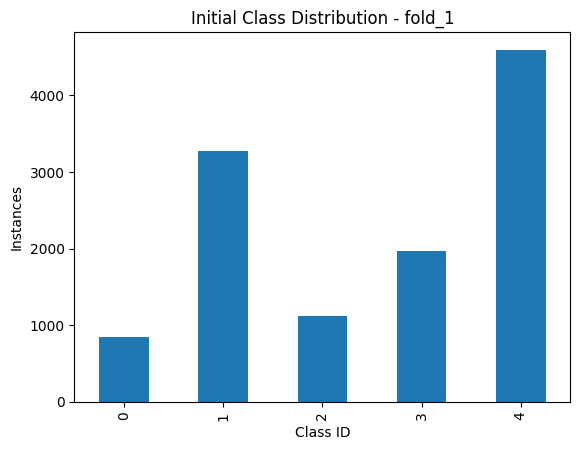


🔄 Balancing fold_1...
🚀 Starting Balancing Process for fold_1...
  Copying original dataset from /home/andrea/work/AI-waste-detection/datasets/k_fold_cv/fold_1 to /home/andrea/work/AI-waste-detection/datasets/k_fold_cv_balanced/fold_1...
  Copy complete.
🎯 Target instance count per class: 4594
  Copy complete.
🎯 Target instance count per class: 4594


Balancing fold_1: 100%|██████████| 11167/11167 [04:19<00:00, 43.06it/s]



Balancing complete for fold_1.

📊 Verifying fold_1 after balancing...
📊 Verifying Final Class Distribution for fold_1...

Final Class Distribution for fold_1 (train split):
  - glass (ID 0): 4594 instances
  - metal (ID 1): 4594 instances
  - organic (ID 2): 4594 instances
  - paper (ID 3): 4595 instances
  - plastic (ID 4): 4594 instances

Final Class Distribution for fold_1 (train split):
  - glass (ID 0): 4594 instances
  - metal (ID 1): 4594 instances
  - organic (ID 2): 4594 instances
  - paper (ID 3): 4595 instances
  - plastic (ID 4): 4594 instances


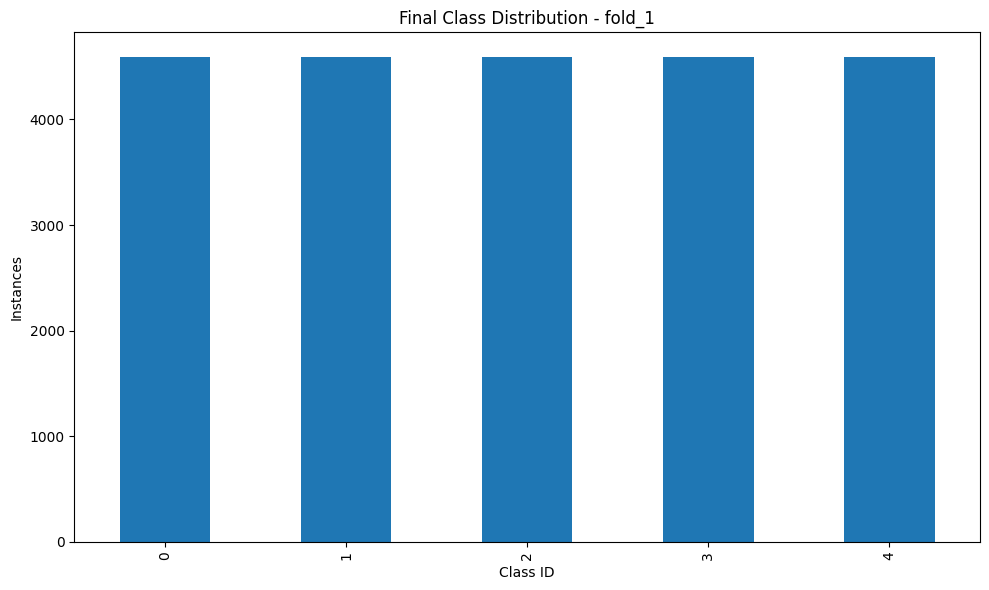


📊 Final verification for fold_1 after subsampling...
📊 Verifying Final Class Distribution for fold_1...

Final Class Distribution for fold_1 (train split):
  - glass (ID 0): 4594 instances
  - metal (ID 1): 4594 instances
  - organic (ID 2): 4594 instances
  - paper (ID 3): 4595 instances
  - plastic (ID 4): 4594 instances

Final Class Distribution for fold_1 (train split):
  - glass (ID 0): 4594 instances
  - metal (ID 1): 4594 instances
  - organic (ID 2): 4594 instances
  - paper (ID 3): 4595 instances
  - plastic (ID 4): 4594 instances


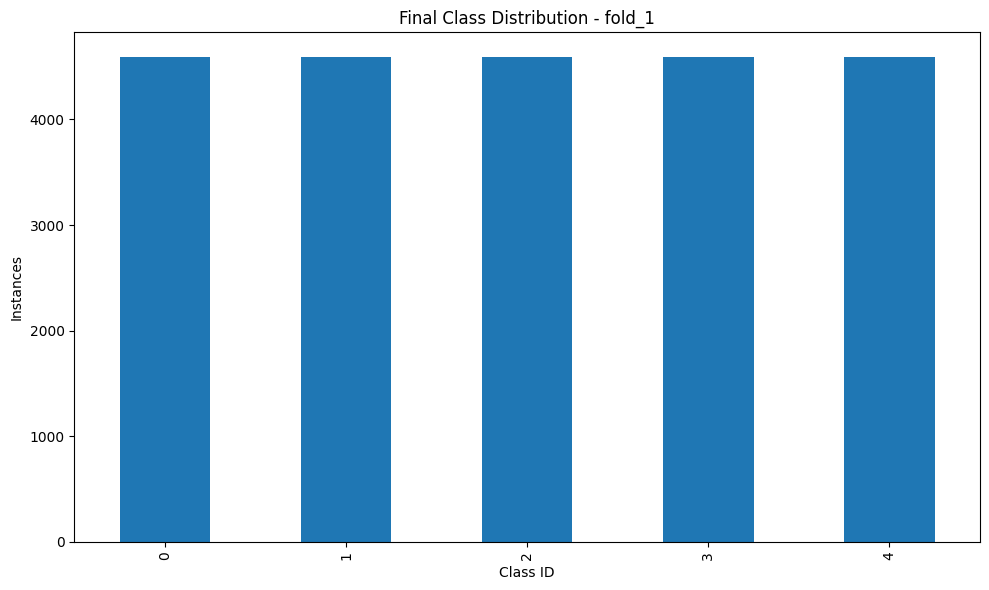

✅ fold_1 processing complete!

🗂️  PROCESSING FOLD_2
Target classes from data.yaml: ['glass', 'metal', 'organic', 'paper', 'plastic']

Initial Class Distribution for fold_2 (train split):
  - glass (ID 0): 853 instances
  - metal (ID 1): 3358 instances
  - organic (ID 2): 1125 instances
  - paper (ID 3): 1946 instances
  - plastic (ID 4): 4690 instances

Initial Class Distribution for fold_2 (train split):
  - glass (ID 0): 853 instances
  - metal (ID 1): 3358 instances
  - organic (ID 2): 1125 instances
  - paper (ID 3): 1946 instances
  - plastic (ID 4): 4690 instances


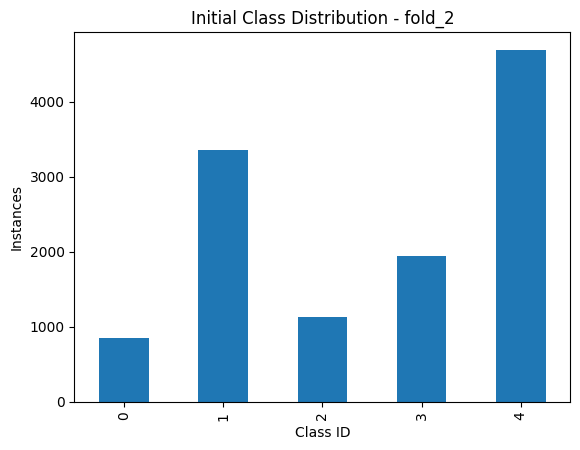


🔄 Balancing fold_2...
🚀 Starting Balancing Process for fold_2...
  Copying original dataset from /home/andrea/work/AI-waste-detection/datasets/k_fold_cv/fold_2 to /home/andrea/work/AI-waste-detection/datasets/k_fold_cv_balanced/fold_2...
  Copy complete.
🎯 Target instance count per class: 4690
  Copy complete.
🎯 Target instance count per class: 4690


Balancing fold_2: 100%|██████████| 11478/11478 [04:38<00:00, 41.24it/s]



Balancing complete for fold_2.

📊 Verifying fold_2 after balancing...
📊 Verifying Final Class Distribution for fold_2...

Final Class Distribution for fold_2 (train split):
  - glass (ID 0): 4690 instances
  - metal (ID 1): 4691 instances
  - organic (ID 2): 4690 instances
  - paper (ID 3): 4690 instances
  - plastic (ID 4): 4690 instances

Final Class Distribution for fold_2 (train split):
  - glass (ID 0): 4690 instances
  - metal (ID 1): 4691 instances
  - organic (ID 2): 4690 instances
  - paper (ID 3): 4690 instances
  - plastic (ID 4): 4690 instances


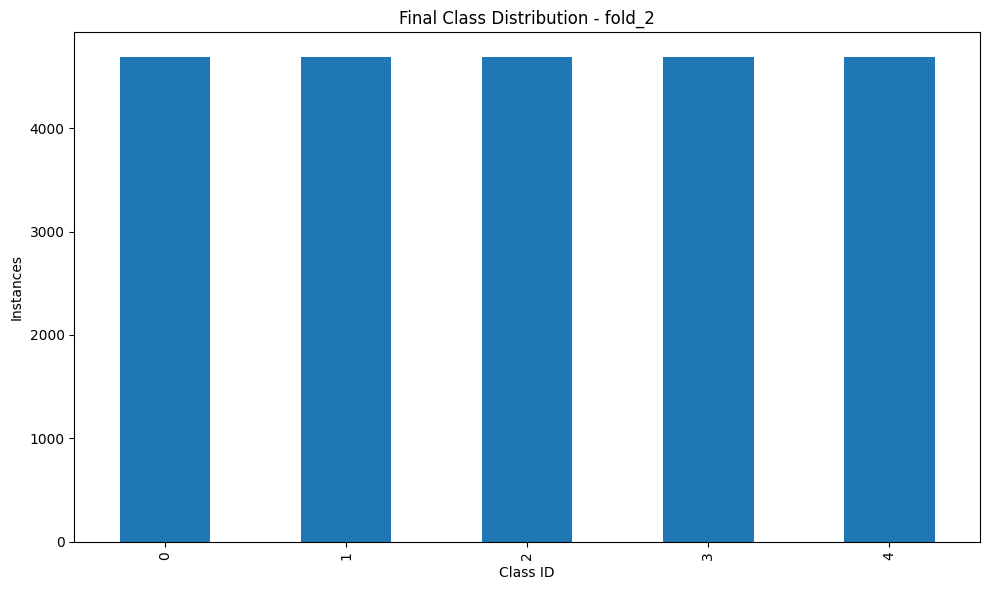


📊 Final verification for fold_2 after subsampling...
📊 Verifying Final Class Distribution for fold_2...

Final Class Distribution for fold_2 (train split):
  - glass (ID 0): 4690 instances
  - metal (ID 1): 4691 instances
  - organic (ID 2): 4690 instances
  - paper (ID 3): 4690 instances
  - plastic (ID 4): 4690 instances

Final Class Distribution for fold_2 (train split):
  - glass (ID 0): 4690 instances
  - metal (ID 1): 4691 instances
  - organic (ID 2): 4690 instances
  - paper (ID 3): 4690 instances
  - plastic (ID 4): 4690 instances


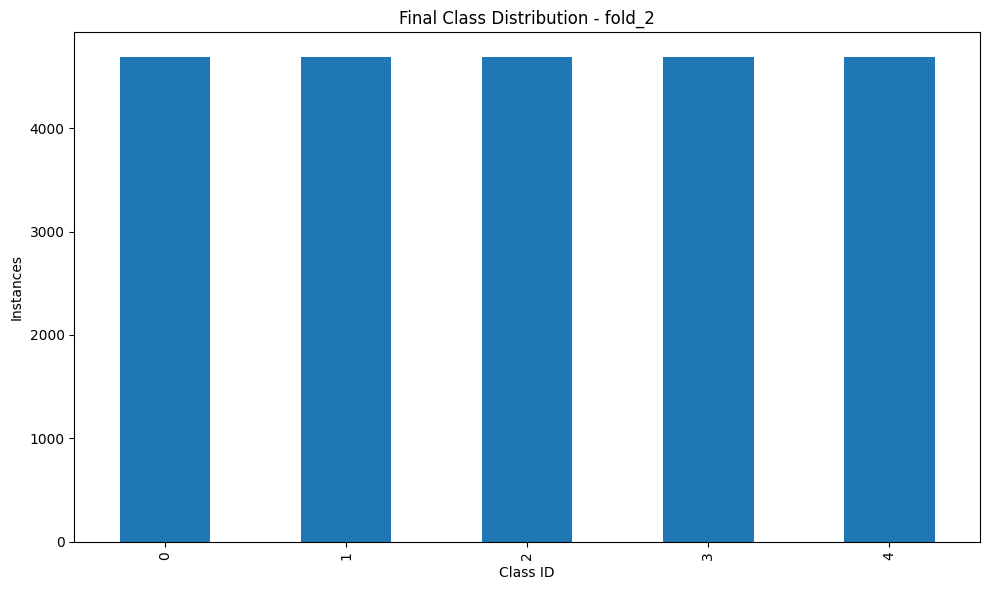

✅ fold_2 processing complete!

🗂️  PROCESSING FOLD_3
Target classes from data.yaml: ['glass', 'metal', 'organic', 'paper', 'plastic']

Initial Class Distribution for fold_3 (train split):
  - glass (ID 0): 869 instances
  - metal (ID 1): 3308 instances
  - organic (ID 2): 1117 instances
  - paper (ID 3): 1961 instances
  - plastic (ID 4): 4470 instances

Initial Class Distribution for fold_3 (train split):
  - glass (ID 0): 869 instances
  - metal (ID 1): 3308 instances
  - organic (ID 2): 1117 instances
  - paper (ID 3): 1961 instances
  - plastic (ID 4): 4470 instances


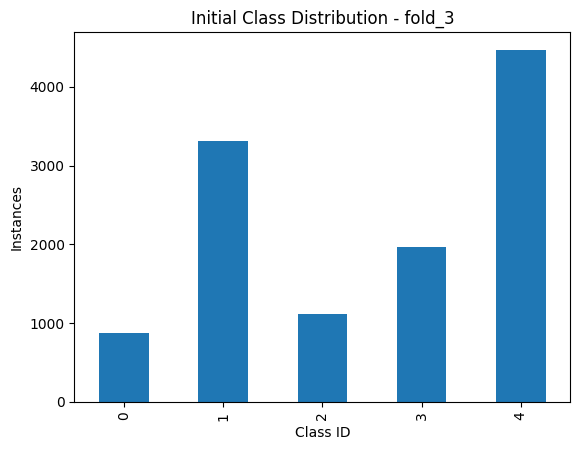


🔄 Balancing fold_3...
🚀 Starting Balancing Process for fold_3...
  Copying original dataset from /home/andrea/work/AI-waste-detection/datasets/k_fold_cv/fold_3 to /home/andrea/work/AI-waste-detection/datasets/k_fold_cv_balanced/fold_3...
  Copy complete.
🎯 Target instance count per class: 4470
  Copy complete.
🎯 Target instance count per class: 4470


Balancing fold_3: 100%|██████████| 10625/10625 [04:09<00:00, 42.64it/s]



Balancing complete for fold_3.

📊 Verifying fold_3 after balancing...
📊 Verifying Final Class Distribution for fold_3...

Final Class Distribution for fold_3 (train split):
  - glass (ID 0): 4470 instances
  - metal (ID 1): 4470 instances
  - organic (ID 2): 4470 instances
  - paper (ID 3): 4470 instances
  - plastic (ID 4): 4470 instances

Final Class Distribution for fold_3 (train split):
  - glass (ID 0): 4470 instances
  - metal (ID 1): 4470 instances
  - organic (ID 2): 4470 instances
  - paper (ID 3): 4470 instances
  - plastic (ID 4): 4470 instances


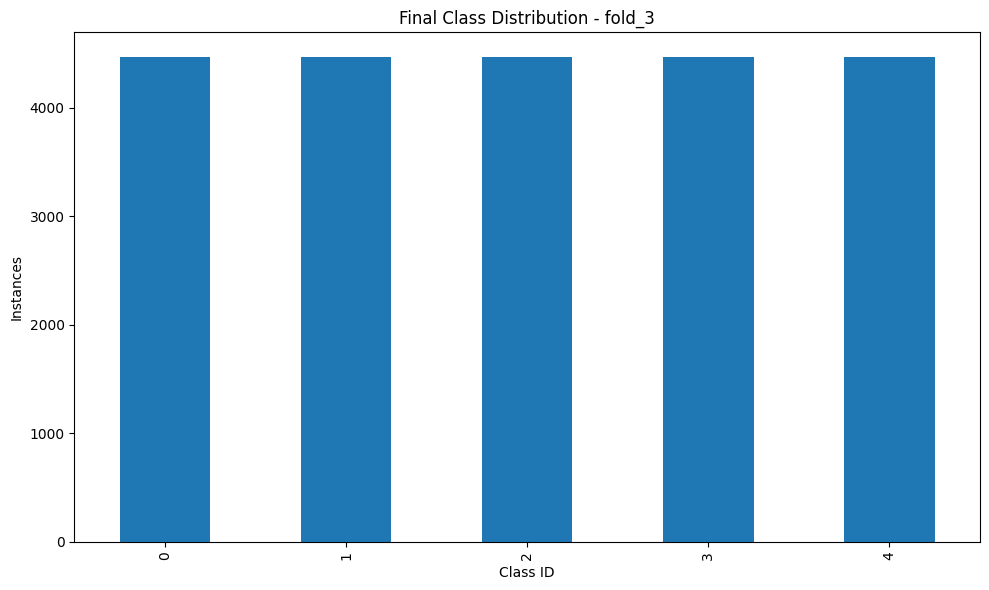


📊 Final verification for fold_3 after subsampling...
📊 Verifying Final Class Distribution for fold_3...

Final Class Distribution for fold_3 (train split):
  - glass (ID 0): 4470 instances
  - metal (ID 1): 4470 instances
  - organic (ID 2): 4470 instances
  - paper (ID 3): 4470 instances
  - plastic (ID 4): 4470 instances

Final Class Distribution for fold_3 (train split):
  - glass (ID 0): 4470 instances
  - metal (ID 1): 4470 instances
  - organic (ID 2): 4470 instances
  - paper (ID 3): 4470 instances
  - plastic (ID 4): 4470 instances


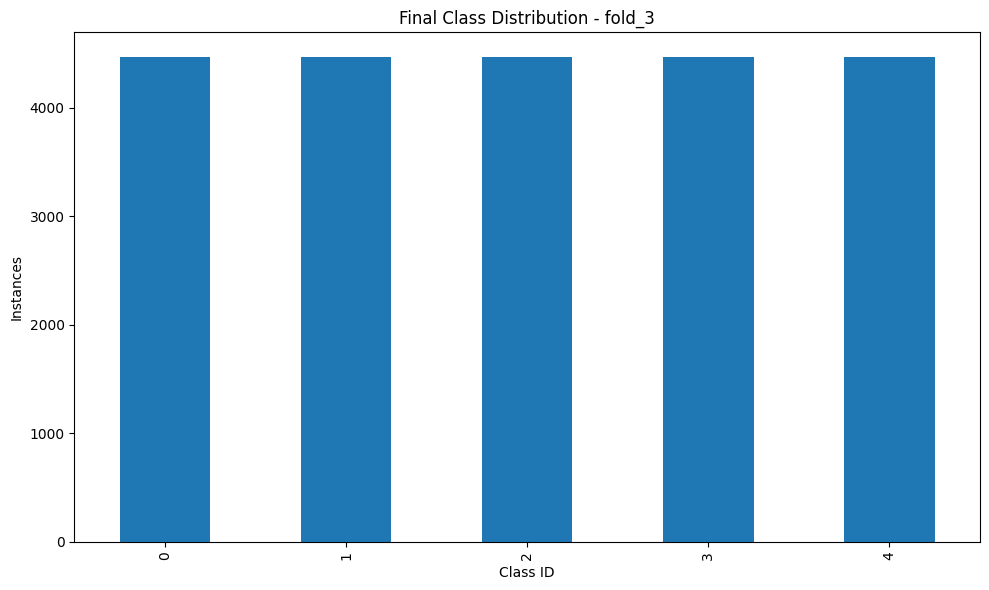

✅ fold_3 processing complete!

🗂️  PROCESSING FOLD_4
Target classes from data.yaml: ['glass', 'metal', 'organic', 'paper', 'plastic']

Initial Class Distribution for fold_4 (train split):
  - glass (ID 0): 834 instances
  - metal (ID 1): 3332 instances
  - organic (ID 2): 1117 instances
  - paper (ID 3): 1965 instances
  - plastic (ID 4): 4688 instances

Initial Class Distribution for fold_4 (train split):
  - glass (ID 0): 834 instances
  - metal (ID 1): 3332 instances
  - organic (ID 2): 1117 instances
  - paper (ID 3): 1965 instances
  - plastic (ID 4): 4688 instances


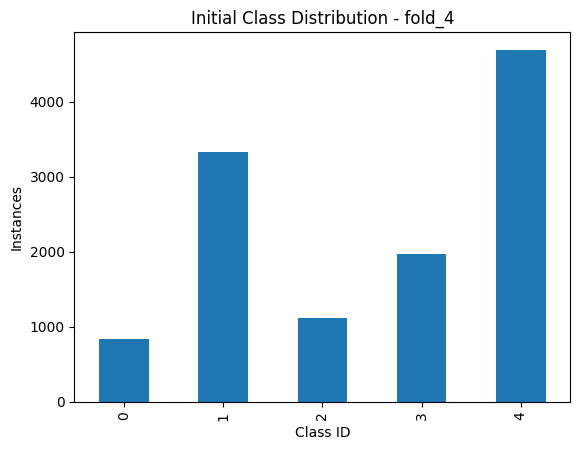


🔄 Balancing fold_4...
🚀 Starting Balancing Process for fold_4...
  Copying original dataset from /home/andrea/work/AI-waste-detection/datasets/k_fold_cv/fold_4 to /home/andrea/work/AI-waste-detection/datasets/k_fold_cv_balanced/fold_4...
  Copy complete.
🎯 Target instance count per class: 4688
  Copy complete.
🎯 Target instance count per class: 4688


Balancing fold_4: 100%|██████████| 11504/11504 [04:32<00:00, 42.27it/s]



Balancing complete for fold_4.

📊 Verifying fold_4 after balancing...
📊 Verifying Final Class Distribution for fold_4...

Final Class Distribution for fold_4 (train split):
  - glass (ID 0): 4689 instances
  - metal (ID 1): 4688 instances
  - organic (ID 2): 4688 instances
  - paper (ID 3): 4688 instances
  - plastic (ID 4): 4688 instances

Final Class Distribution for fold_4 (train split):
  - glass (ID 0): 4689 instances
  - metal (ID 1): 4688 instances
  - organic (ID 2): 4688 instances
  - paper (ID 3): 4688 instances
  - plastic (ID 4): 4688 instances


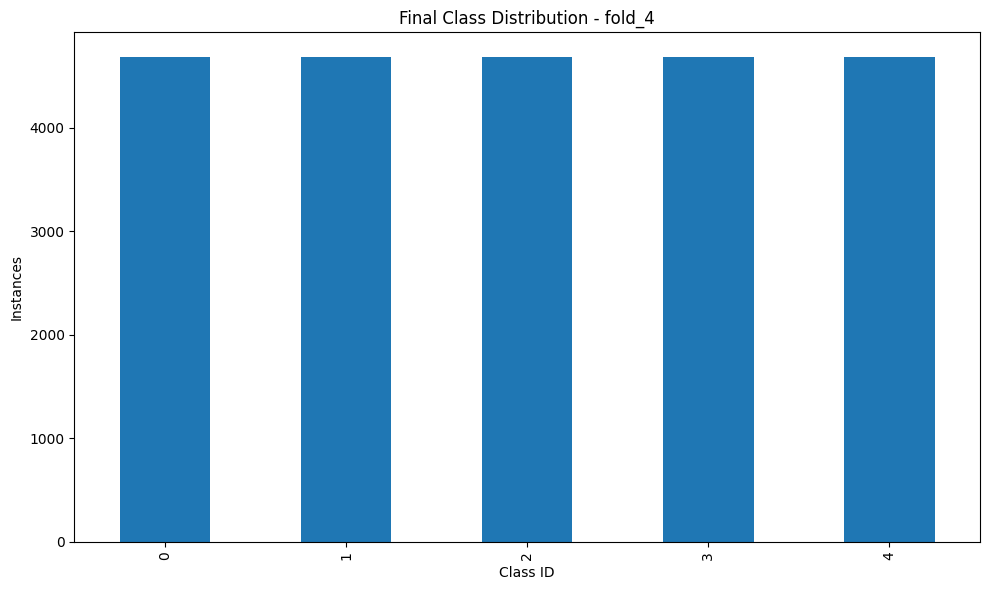


📊 Final verification for fold_4 after subsampling...
📊 Verifying Final Class Distribution for fold_4...

Final Class Distribution for fold_4 (train split):
  - glass (ID 0): 4689 instances
  - metal (ID 1): 4688 instances
  - organic (ID 2): 4688 instances
  - paper (ID 3): 4688 instances
  - plastic (ID 4): 4688 instances

Final Class Distribution for fold_4 (train split):
  - glass (ID 0): 4689 instances
  - metal (ID 1): 4688 instances
  - organic (ID 2): 4688 instances
  - paper (ID 3): 4688 instances
  - plastic (ID 4): 4688 instances


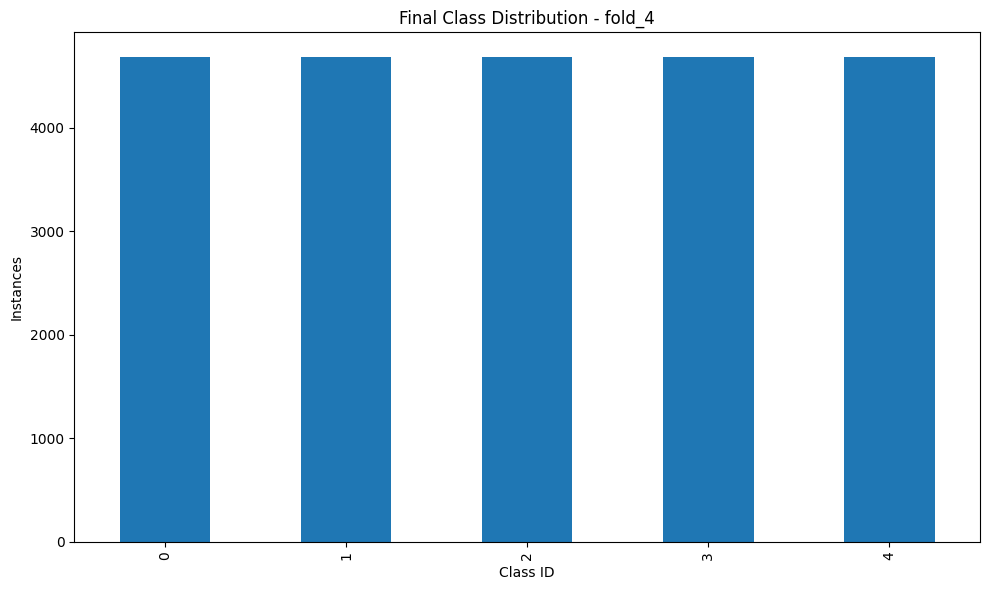

✅ fold_4 processing complete!

🗂️  PROCESSING FOLD_5
Target classes from data.yaml: ['glass', 'metal', 'organic', 'paper', 'plastic']

Initial Class Distribution for fold_5 (train split):
  - glass (ID 0): 881 instances
  - metal (ID 1): 3335 instances
  - organic (ID 2): 1123 instances
  - paper (ID 3): 1937 instances
  - plastic (ID 4): 4672 instances

Initial Class Distribution for fold_5 (train split):
  - glass (ID 0): 881 instances
  - metal (ID 1): 3335 instances
  - organic (ID 2): 1123 instances
  - paper (ID 3): 1937 instances
  - plastic (ID 4): 4672 instances


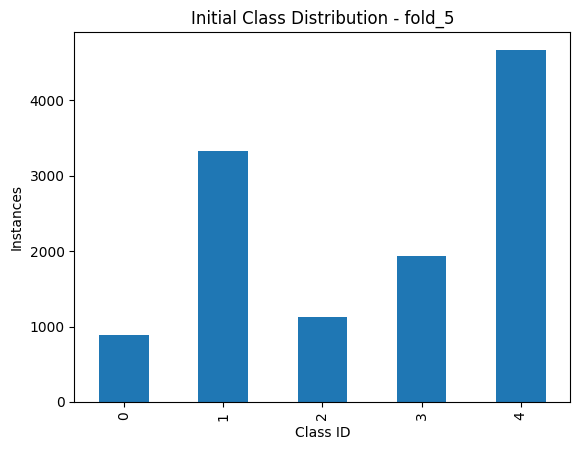


🔄 Balancing fold_5...
🚀 Starting Balancing Process for fold_5...
  Copying original dataset from /home/andrea/work/AI-waste-detection/datasets/k_fold_cv/fold_5 to /home/andrea/work/AI-waste-detection/datasets/k_fold_cv_balanced/fold_5...
  Copy complete.
🎯 Target instance count per class: 4672
  Copy complete.
🎯 Target instance count per class: 4672


Balancing fold_5: 100%|██████████| 11412/11412 [04:35<00:00, 41.37it/s]



Balancing complete for fold_5.

📊 Verifying fold_5 after balancing...
📊 Verifying Final Class Distribution for fold_5...

Final Class Distribution for fold_5 (train split):
  - glass (ID 0): 4672 instances
  - metal (ID 1): 4672 instances
  - organic (ID 2): 4672 instances
  - paper (ID 3): 4672 instances
  - plastic (ID 4): 4672 instances

Final Class Distribution for fold_5 (train split):
  - glass (ID 0): 4672 instances
  - metal (ID 1): 4672 instances
  - organic (ID 2): 4672 instances
  - paper (ID 3): 4672 instances
  - plastic (ID 4): 4672 instances


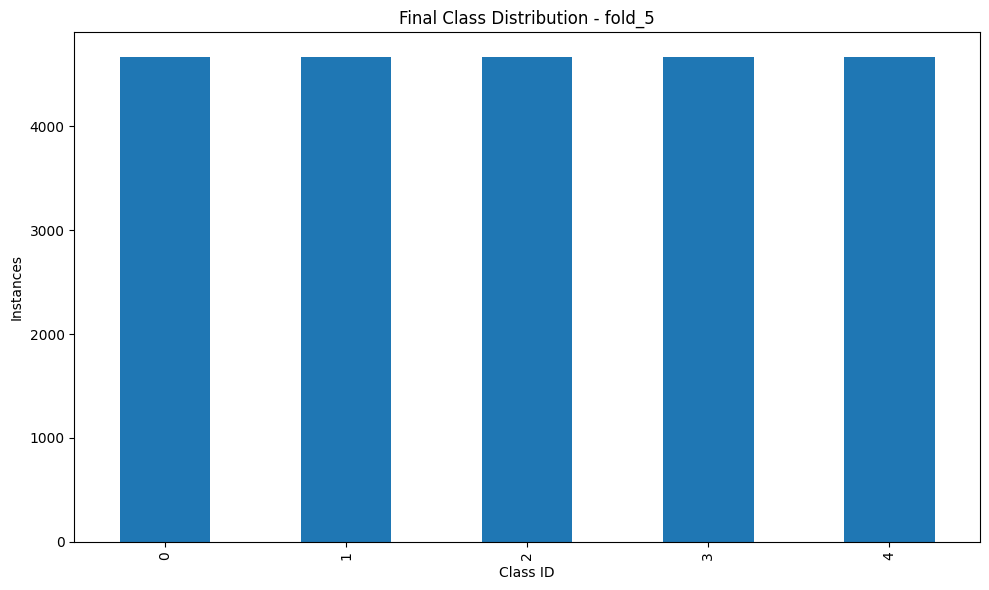


📊 Final verification for fold_5 after subsampling...
📊 Verifying Final Class Distribution for fold_5...

Final Class Distribution for fold_5 (train split):
  - glass (ID 0): 4672 instances
  - metal (ID 1): 4672 instances
  - organic (ID 2): 4672 instances
  - paper (ID 3): 4672 instances
  - plastic (ID 4): 4672 instances

Final Class Distribution for fold_5 (train split):
  - glass (ID 0): 4672 instances
  - metal (ID 1): 4672 instances
  - organic (ID 2): 4672 instances
  - paper (ID 3): 4672 instances
  - plastic (ID 4): 4672 instances


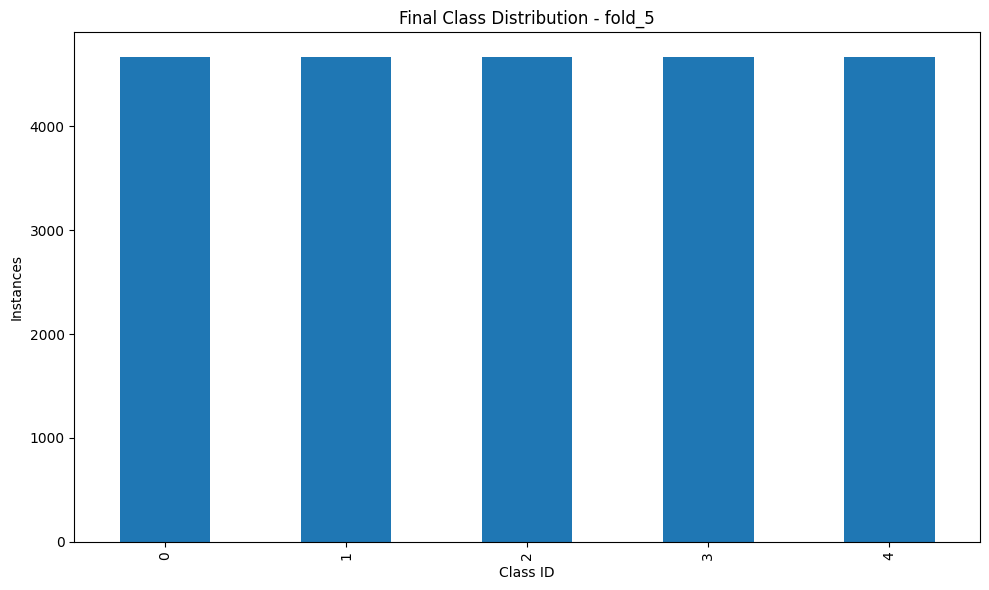

✅ fold_5 processing complete!

🎉 ALL FOLDS PROCESSING FINISHED!
Processed 5 folds:
  ✅ fold_1
  ✅ fold_2
  ✅ fold_3
  ✅ fold_4
  ✅ fold_5

Balanced datasets saved to: /home/andrea/work/AI-waste-detection/datasets/k_fold_cv_balanced


In [9]:
# Step 1: Create the object bank (only needs to be done once)
# Note: This can take a long time. Run it once.
# If the object bank is already created, you can comment this line out.
if not any(OBJECT_BANK_DIR.glob('*/')) or len(list(OBJECT_BANK_DIR.glob('*/'))) == 0:
    print("Creating object bank...")
    create_object_bank()
else:
    print("Object bank already exists, skipping creation...")

# Step 2: Load the object bank
object_bank = load_object_bank()

if not any(object_bank.values()):
    print("❌ Cannot proceed: Object bank is empty.")
else:
    print(f"🚀 Starting processing of all {len(AVAILABLE_FOLDS)} folds...")
    
    # Process each fold
    for fold_name in AVAILABLE_FOLDS:
        print(f"\n{'='*60}")
        print(f"🗂️  PROCESSING {fold_name.upper()}")
        print(f"{'='*60}")
        
        # Step 3: Analyze the fold
        target_classes, num_classes, initial_dist = analyze_fold_distribution(fold_name)
        
        if not target_classes:
            print(f"❌ Skipping {fold_name}: Could not load fold configuration.")
            continue
        
        # Step 4: Balance the fold
        print(f"\n🔄 Balancing {fold_name}...")
        balanced_fold_dir = balance_fold(object_bank, fold_name, target_classes, num_classes)
        
        # Step 5: Verify the results
        print(f"\n📊 Verifying {fold_name} after balancing...")
        verify_balancing(fold_name, target_classes, num_classes)
        
        # # Step 6: Subsample the training set
        # print(f"\n📉 Subsampling {fold_name}...")
        # subsample_training_set(fold_name, target_classes, num_classes)
        
        # Step 7: Final verification after subsampling
        print(f"\n📊 Final verification for {fold_name} after subsampling...")
        final_dist = verify_balancing(fold_name, target_classes, num_classes)
        
        print(f"✅ {fold_name} processing complete!")
    
    print(f"\n{'='*60}")
    print("🎉 ALL FOLDS PROCESSING FINISHED!")
    print(f"{'='*60}")
    print(f"Processed {len(AVAILABLE_FOLDS)} folds:")
    for fold_name in AVAILABLE_FOLDS:
        print(f"  ✅ {fold_name}")
    print(f"\nBalanced datasets saved to: {BALANCED_FOLDS_DIR}")

## 7. Summary Analysis (Optional)

Run this cell to get a comprehensive summary of all processed folds.

📋 SUMMARY ANALYSIS OF ALL FOLDS

fold_1:
  Status: ✅ Processed
  Original instances: 11803
  Balanced instances: 22971
  Size change: +11168 (+94.6%)

fold_1:
  Status: ✅ Processed
  Original instances: 11803
  Balanced instances: 22971
  Size change: +11168 (+94.6%)

fold_2:
  Status: ✅ Processed
  Original instances: 11972
  Balanced instances: 23451
  Size change: +11479 (+95.9%)

fold_2:
  Status: ✅ Processed
  Original instances: 11972
  Balanced instances: 23451
  Size change: +11479 (+95.9%)

fold_3:
  Status: ✅ Processed
  Original instances: 11725
  Balanced instances: 22350
  Size change: +10625 (+90.6%)

fold_3:
  Status: ✅ Processed
  Original instances: 11725
  Balanced instances: 22350
  Size change: +10625 (+90.6%)

fold_4:
  Status: ✅ Processed
  Original instances: 11936
  Balanced instances: 23441
  Size change: +11505 (+96.4%)

fold_4:
  Status: ✅ Processed
  Original instances: 11936
  Balanced instances: 23441
  Size change: +11505 (+96.4%)

fold_5:
  Status: ✅ Pro

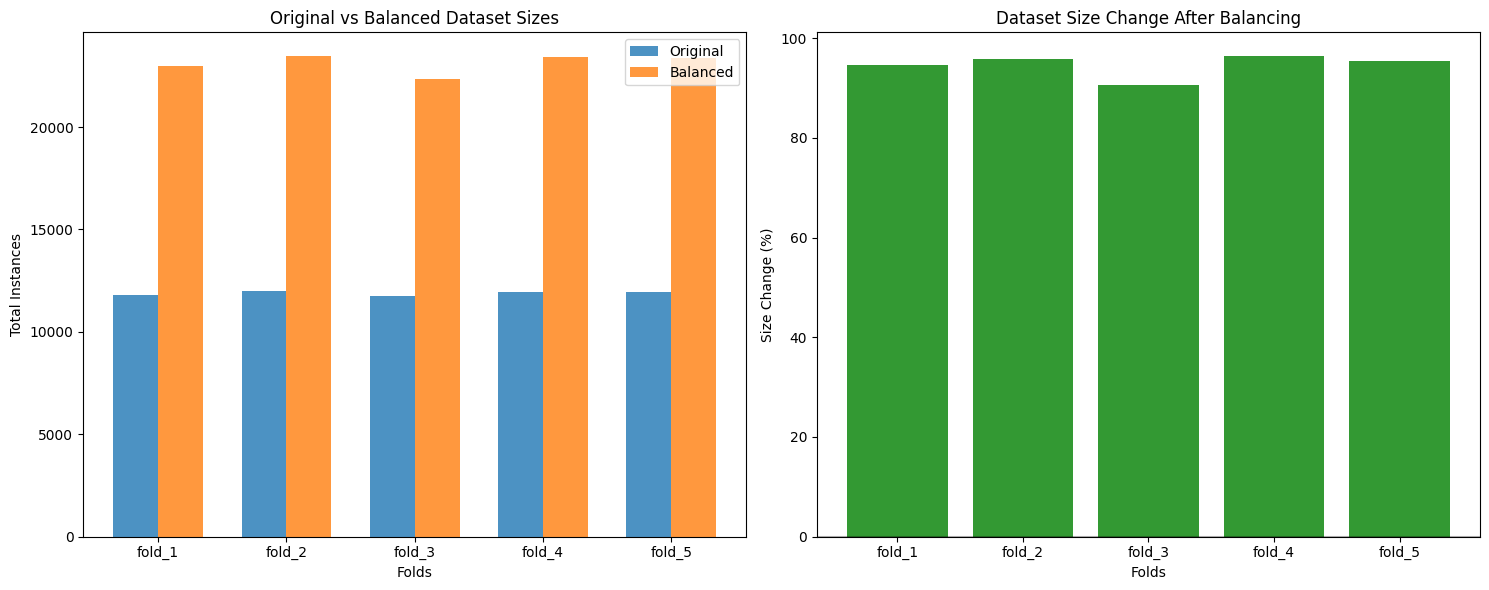


🎯 Processing complete for 5 out of 5 folds.


In [10]:
# Run this to get a summary of all processed folds
analyze_all_folds_summary()